<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [1]:
# Import PyTorch and supporting libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [33]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


MPS backend is available. Running on Apple GPU.


In [34]:
device = torch.device("mps")  # Use MPS for Apple Silicon
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("Tensor on MPS:", x)


Tensor on MPS: tensor([1., 2., 3.], device='mps:0')


In [35]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Load the CSV file
# train data
train_csv_path = "data/train_images.csv"
train_label_df = pd.read_csv(train_csv_path)

# test data
test_csv_path = "data/test_images_path.csv"  # Update this path
test_label_df = pd.read_csv(test_csv_path)
# Drop the 'id' column
test_label_df = test_label_df.drop(columns=['id'])


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/train_images/"+self.data.iloc[idx, 0]  # Image file path
        label = self.data.iloc[idx, 1]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [39]:
class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/test_images/"+self.data.iloc[idx, 1]  # Image file path
        label = self.data.iloc[idx, 2]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# pre-process the data
# Define a transformation pipeline with resizing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 256x256
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# # Instantiate the dataset
# dataset_train = CustomDataset(
#     csv_file="./data/train_images.csv",     # Path to your labels CSV
#     root_dir="./data/train_images",   # Directory containing the images
#     transform=transform
# )

batch_size = 4
learning_rate = 0.001
num_epochs = 20

# # Create a DataLoader
# train_loader = DataLoader(dataset_train, batch_size, shuffle=True)

# Instantiate the dataset
train_dataset = CustomDataset(csv_file=train_csv_path, transform=transform)
test_dataset = TestDataset(csv_file=test_csv_path, transform=transform)

# Create a DataLoader for batch processing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # set batch size to 1 so that we check all 4000 images


In [ ]:
# Test the DataLoader
for images, labels in train_dataloader:
    print(f"Image batch shape: {images.shape}")  # Expect [batch_size, channels, height, width]
    print(f"Label batch shape: {labels.shape}")  # Expect [batch_size]
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Image batch shape: torch.Size([4, 3, 128, 128])
Label batch shape: torch.Size([4])

Batch of images: torch.Size([1, 3, 128, 128])
Batch of labels: tensor([1])


In [42]:
# Access a batch of data
images, labels = next(iter(train_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in train_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([4, 3, 128, 128])
Batch of Labels: tensor([153, 125, 175, 111])
Maximum label: 200
Number of classes: 200


In [63]:
# Step 5: Verify the Dataset

# Iterate through the train DataLoader
for images, labels in train_dataloader:
    print(f"Batch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Batch of images: torch.Size([4, 3, 128, 128])
Batch of labels: tensor([ 78, 107,  86, 143])

Batch of images: torch.Size([1, 3, 128, 128])
Batch of labels: tensor([1])


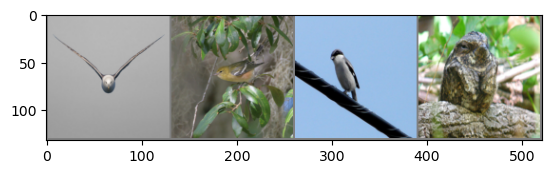

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [79]:
#Step 2: Define a simple CNN model
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)  # 16 channels * 64x64 image size
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
net = SimpleCNN().to(device)

In [80]:
# Step 2.1: Initialize the model
print(net)

# Step 3: Define a loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=200, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [81]:

# # train the network
# for epoch in range(2):  # loop over the dataset multiple times
#     net.train()  # Set model to training mode
#     running_loss = 0.0
#     for i, data in enumerate(train_dataloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels-1)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         #if i % 2000 == 1999:    # print every 2000 mini-batches
#         #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#         running_loss = 0.0
#     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
# print('Finished Training')
total = 0
correct = 0

# Step 8: Training loop

for epoch in range(num_epochs):
    net.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_dataloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels - 1) # to combat the out of bounds issue I set labels - 1 

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss for display
        running_loss += loss.item()
        total += labels.size(0)
        batch_correct = (torch.argmax(outputs, 1)+1 == labels).sum().item()
        correct += batch_correct
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Accuracy: {correct/total * 100:.2f}%")



Epoch [1/20], Loss: 5.4941, Accuracy: 3.21%
Epoch [2/20], Loss: 2.2743, Accuracy: 31.78%
Epoch [3/20], Loss: 0.6862, Accuracy: 51.83%
Epoch [4/20], Loss: 0.1997, Accuracy: 63.49%
Epoch [5/20], Loss: 0.0676, Accuracy: 70.71%
Epoch [6/20], Loss: 0.0280, Accuracy: 75.57%
Epoch [7/20], Loss: 0.0113, Accuracy: 79.06%
Epoch [8/20], Loss: 0.0070, Accuracy: 81.67%
Epoch [9/20], Loss: 0.0058, Accuracy: 83.70%
Epoch [10/20], Loss: 0.0047, Accuracy: 85.33%
Epoch [11/20], Loss: 0.0019, Accuracy: 86.66%
Epoch [12/20], Loss: 0.0028, Accuracy: 87.77%
Epoch [13/20], Loss: 0.0118, Accuracy: 88.70%
Epoch [14/20], Loss: 0.0004, Accuracy: 89.51%
Epoch [15/20], Loss: 0.0003, Accuracy: 90.21%
Epoch [16/20], Loss: 0.0002, Accuracy: 90.82%
Epoch [17/20], Loss: 0.0001, Accuracy: 91.36%
Epoch [18/20], Loss: 0.0003, Accuracy: 91.84%
Epoch [19/20], Loss: 0.0089, Accuracy: 92.25%
Epoch [20/20], Loss: 0.0001, Accuracy: 92.64%


In [ ]:
# Evaluate the model

# Assume `net` is your trained model and `device` is your computation device (CPU/GPU)
net.eval()  # Set the model to evaluation mode

predictions = []
all_labels = []
# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
count = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        preds += 1

        # get the current images' image path
        image_path = test_label_df["image_path"][count]

        # Extract the file name without the extension
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        
        # Store the image path and prediction
        predictions.append((image_name, preds.item()))
        count += 1

# # Save predictions to Excel
# df = pd.DataFrame(predictions, columns=['id', 'label'])
# df.to_csv("predictions.csv", index=False)
# Save predictions to Excel
df = pd.DataFrame(predictions, columns=['id', 'label'])
df.to_csv("predictions.csv", index=False)


#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Calculate accuracy
# accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
# print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model's state dictionary
torch.save(net.state_dict(), "christinaperdue_net.pth")

In [89]:
df = pd.DataFrame(predictions, columns=['id', 'label'])
df.to_csv("predictions.csv", index=False)

In [90]:
# Save and load the model
# Save the model's state dictionary
torch.save(net.state_dict(), "christinaperdue_net.pth")
model = SimpleCNN()  # Replace `MyModel` with your model's class
model.load_state_dict(torch.load('christinaperdue_net.pth'))
model.eval()  # Set the model to evaluation mode if you're not training

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=200, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [111]:
from PIL import Image
import numpy as np

# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure RGB format
    return preprocess(image).unsqueeze(0)  # Add batch dimension


# Training image (used during model training)
test_image_path = 'data/test_images/test_images/390.jpg'

# Use the test image for LIME
image_tensor = preprocess_image(test_image_path)


In [112]:
def predict_fn(images):
    """
    LIME requires NumPy arrays as input. This function:
    1. Converts NumPy arrays to PyTorch tensors.
    2. Passes them through the model.
    3. Returns probabilities as a NumPy array.
    """
    images_tensor = torch.from_numpy(images).permute(0, 3, 1, 2).float()  # Convert NHWC to NCHW
    outputs = model(images_tensor)
    probabilities = torch.nn.functional.softmax(outputs, dim=1).detach().numpy()
    return probabilities

In [113]:
from lime.lime_image import LimeImageExplainer

explainer = LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(
    image=image_tensor.squeeze().permute(1, 2, 0).numpy(),  # Convert tensor to HWC NumPy array
    classifier_fn=predict_fn,  # The prediction function
    top_labels=1,  # Number of top labels to explain
    hide_color=0,  # Color for hidden regions
    num_samples=1000  # Number of perturbations
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7870152..2.465708].


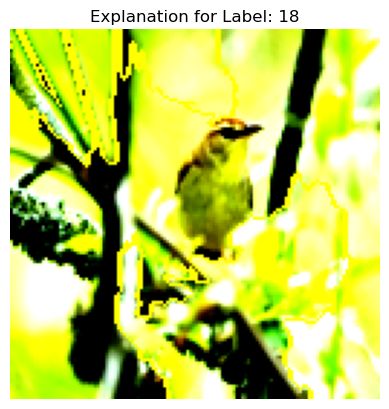

In [115]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Get the explanation for the top label
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=label,
    positive_only=True,  # Show only positive contributions
    num_features=5,  # Number of superpixels to show
    hide_rest=False  # Whether to hide other parts of the image
)

# Plot the explanation
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"Explanation for Label: {label}")
plt.axis('off')
plt.show()